In [1]:
#import optshrink as opt # package we create
import numpy as np
# import scipy.io as sio
import h5py
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import skimage
import os
from skimage import io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import re
import numpy as np
import seaborn as sn
## for the stats class
import scipy.signal as sg
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.decomposition import SparsePCA
import pywt
from scipy import stats

In [ ]:
image_dir = '/home/smmrrr/Fog_Imaging_Project/image_data/'
image_files = os.listdir(image_dir) 


In [4]:
f = '1537729200.Sun.Aug.03_19_00_00.GMT.2015.argus00.c0.snap.jpg'
bool(re.search(r'Aug\.[0-1].*2015', f))

project_files = []

for f in image_files:
    if bool(re.search(r'Aug\.[0-1].*2015', f)):
        project_files.append(f)     

len(project_files)

243

In [8]:
fog_labels = pd.read_csv('~/Fog_Imaging_Project/sta251project/manual_fog_labels_aug2015.csv')
fog_labels = fog_labels.fillna(0)
df_project_files = pd.DataFrame(project_files, columns = ['image'])
df_project_files['counts'] = df_project_files.index
df_project_files = df_project_files.merge(fog_labels, on = 'image')
df_project_files['fog'] = df_project_files['foggy over ocean ']
df_project_files['fog_labels'] = np.where(df_project_files['fog'] == 0, 'clear', 'fog')

df_project_files['fog']

0      1.0
1      1.0
2      0.0
3      0.0
4      0.0
      ... 
238    0.0
239    0.0
240    1.0
241    0.0
242    1.0
Name: fog, Length: 243, dtype: float64

In [9]:
# for f in range(len(project_files)):
#     im = io.imread(image_dir + project_files[f])
#     im = im[110:950, :, :]
#     im = rgb2gray(im)
#     if f == 0 :
#         all_pixels = im.ravel()
#     else:
#         all_pixels = np.vstack(( all_pixels, im.ravel()))

    
# all_pixels.shape   

(243, 1075200)

In [10]:
for f in range(len(project_files)):
    im = io.imread(image_dir + project_files[f])
    im = im[110:950, :, :]
    im = rgb2gray(im)
    im = rescale(im, 0.1, anti_aliasing=False)
    coeffs = pywt.dwt2(im, 'db6') ## 6 or 8 for daub
    LL, (LH, HL, HH) = coeffs
    if f == 0 :
        wavelet_images_nono = np.hstack((LL,LH, HL, HH) ).ravel()
    else:
        wavelet_images_nono = np.vstack(( wavelet_images_nono, np.hstack((LL,LH, HL, HH) ).ravel()))

    
wavelet_images_nono.shape    

(243, 12972)

In [267]:
import timeit 
start = timeit.default_timer()
transformer_no = SparsePCA(n_components=50, random_state=0)
transformer_no.fit(wavelet_images_nono)

X_transformed_no = transformer_no.transform(wavelet_images_nono)

print(X_transformed_no.shape)

np.mean(transformer_no.components_ == 0)

print('SPCA', np.round((timeit.default_timer() - start)/60, 2), 'minutes')

(243, 50)
SPCA 4.99 minutes


In [264]:
Q, R = scipy.linalg.qr(wavelet_images_nono)
sum(np.diag(R)**2)

116.69343454259447

In [268]:
import scipy.linalg 
# QR decomposition of modified PCs
Q, R = scipy.linalg.qr(X_transformed_no)
np.diag(R)**2
# # compute adjusted variance
# variance_z_spca_qr_aproach = diag(r_spca)^2/(n-1)
# total_var_spca_qr_aproach = sum(variance_z_spca_qr_aproach)


array([558.99064827, 967.18469884, 132.83259156, 705.28746504,
        81.80154735,  36.68179727, 125.17676294, 108.43444226,
        60.82887074,  55.53344986,  32.93809758,  34.07902812,
        45.58731984, 122.00602842,  36.54424833, 111.91660871,
        11.50354588, 149.1504609 ,  34.48515809,  30.50920649,
        15.511715  ,  50.41654245,  28.88169499, 131.96516638,
         2.43482181,  44.66369553,  36.2934475 ,  21.41702969,
        28.69000521,  32.24644417,  14.42515261,  15.04979478,
        44.80471161,  18.4261719 ,  23.3634763 ,  10.20407187,
        27.00377704,   2.1077295 ,   6.21286144,  26.60308441,
         5.1594171 ,  17.66733249,  36.59639351,  17.49761799,
         3.11256693,  18.74395972,  31.54456848,  16.96631773,
        16.49785187,  20.40139585])

In [269]:
var_exp = np.diag(R)**2

total_var = sum(var_exp)

var_exp_per = [(i/total_var) for i in sorted(var_exp, reverse=True)]
np.cumsum(var_exp_per)

array([0.22993275, 0.3976036 , 0.53049472, 0.56595287, 0.5975317 ,
       0.62890432, 0.6586631 , 0.68766808, 0.71427447, 0.74005304,
       0.75950005, 0.77396114, 0.78716334, 0.79914907, 0.80998673,
       0.82063833, 0.83125641, 0.83997693, 0.84867714, 0.85736495,
       0.86599314, 0.87419143, 0.88229318, 0.89012369, 0.89778977,
       0.90528898, 0.91254206, 0.91940822, 0.92622882, 0.93264853,
       0.93897299, 0.94452729, 0.94961884, 0.95446895, 0.95892503,
       0.96330556, 0.96750568, 0.97166546, 0.97569894, 0.97962104,
       0.9833087 , 0.98688655, 0.9903159 , 0.99305068, 0.99547654,
       0.99695355, 0.99818012, 0.99892008, 0.99949892, 1.        ])

In [259]:
var_exp[0]/var_exp.sum()

0.28695620012866757

In [270]:
for alpha in [.2, .5, 1, 1.5]:
    print(alpha)

0.2
0.5
1
1.5


In [277]:
var_exp = []
var_exp.vstack(np.cumsum(var_exp_per))


In [1]:
# import timeit 
# loop_var_exp = []
# loop_total_vars = []
# for alpha in [2, 1.75, 1.5, 1.25, 1, .75, .5, .25, .1]:
#     start = timeit.default_timer()
#     #read in the model
    # transformer_no = SparsePCA(n_components=20, random_state=0, alpha = alpha)
#     transformer_no.fit(wavelet_images_nono)
#     ## get the transformed matrix
#     X_transformed_no = transformer_no.transform(wavelet_images_nono)
#     ## calculate % of variance explained
#     Q, R = scipy.linalg.qr(X_transformed_no)
#     var_exp = np.diag(R)**2

#     total_var = sum(var_exp)

#     var_exp_per = [(i/total_var) for i in sorted(var_exp, reverse=True)]
#     loop_var_exp.append(np.cumsum(var_exp_per))
#     loop_total_vars.append(var_exp)

#     print(alpha)
#     print(np.mean(transformer_no.components_ == 0))
#     print((1- np.mean(transformer_no.components_ == 0) )* 12972)

#     print('SPCA', np.round((timeit.default_timer() - start)/60, 2), 'minutes')


[Text(0.5, 0, 'Sparsity Penalty'), Text(0, 0.5, 'Features Included in SPCA')]

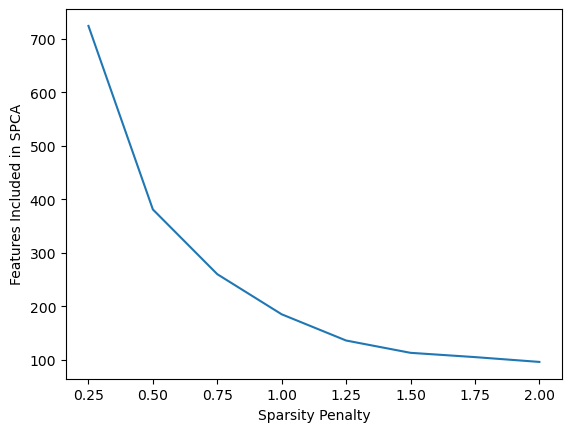

In [331]:
lambdas = [0.25
,0.5
,0.75
,1
,1.25
,1.5
,1.75
,2]

features = [724
,381
,260
,185
,136
,113
,105
,96]
var_expl = np.array(loop_var_exp)[:, 0]

ax = sns.lineplot(x=lambdas, y=features)
ax.set(xlabel="Sparsity Penalty", ylabel = "Features Included in SPCA" )


In [321]:
pd.DataFrame(np.array(loop_var_exp).T, columns = ['alpha.5', 'alpha1', 'alpha1.5'])
         #  ,pd.DataFrame(np.array(loop_total_vars).T, columns = ['tot_alpha.5', 'tot_alpha1', 'tot_alpha1.5'])]
         # axis = 0)

,alpha.5,alpha1,alpha1.5
0,0.278968,0.286956,0.466158
1,0.426340,0.549487,0.560394
2,0.536392,0.612184,0.627191
3,0.611573,0.671313,0.687320
4,0.668066,0.729403,0.739975
5,0.710234,0.772348,0.789735
6,0.750913,0.802752,0.833996
7,0.787777,0.832945,0.873446
8,0.821821,0.858766,0.912820
9,0.854149,0.884399,0.934278


[Text(0.5, 0, 'Sparce Principal Component'),
 Text(0, 0.5, 'Percent of Variance Explained')]

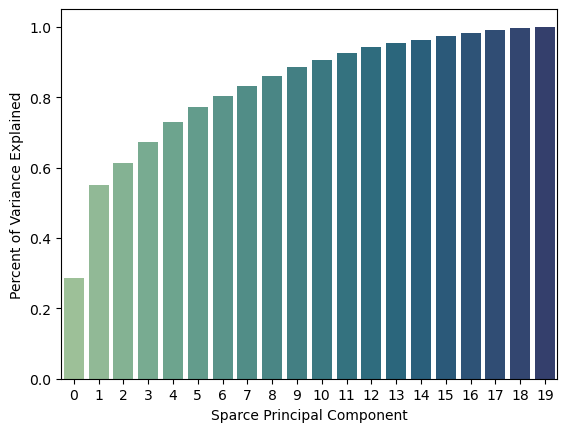

In [320]:
plot_data  = pd.DataFrame(np.array(loop_var_exp).T, columns = ['alpha.5', 'alpha1', 'alpha1.5'])
ax = sns.barplot(data=plot_data, x=plot_data.index, y="alpha1", palette = "crest")
ax.set(xlabel="Sparce Principal Component", ylabel = "Percent of Variance Explained" )


In [2]:
# pd.Index(plot_data)

In [242]:
transformer_no.components_

array([[-0.08761858, -0.08485376, -0.08544872, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [200]:
X = X_transformed_no[:, (0, 16)]
y = np.array(df_project_files['fog'])
# from sklearn.model_selection import StratifiedKFold
# skf = StratifiedKFold(n_splits=2)
# next(skf.split(X, y))
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42)

n_classes = len(np.unique(y_train))


In [207]:

gmm = GaussianMixture(n_components=n_classes,
                    covariance_type='diag', init_params='random_from_data')
gmm.fit(X_train)
y_train_pred = gmm.predict(X_train)
train_accuracy = np.mean(y_train_pred == y_train) * 100
print( 'Train accuracy: %.1f' % train_accuracy)

y_test_pred = gmm.predict(X_test)
test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
print('Test accuracy: %.1f' % test_accuracy)


Train accuracy: 6.2
Test accuracy: 8.2


In [119]:
X

array([[-20.        , -18.97959184, -17.95918367, ...,  27.95918367,
         28.97959184,  30.        ],
       [-20.        , -18.97959184, -17.95918367, ...,  27.95918367,
         28.97959184,  30.        ],
       [-20.        , -18.97959184, -17.95918367, ...,  27.95918367,
         28.97959184,  30.        ],
       ...,
       [-20.        , -18.97959184, -17.95918367, ...,  27.95918367,
         28.97959184,  30.        ],
       [-20.        , -18.97959184, -17.95918367, ...,  27.95918367,
         28.97959184,  30.        ],
       [-20.        , -18.97959184, -17.95918367, ...,  27.95918367,
         28.97959184,  30.        ]])

In [78]:
from sklearn.mixture import GaussianMixture
classifiers = dict((covar_type, GaussianMixture(n_components=n_classes,
                    covariance_type=covar_type, init_params='random_from_data'))
                   for covar_type in ['spherical', 'diag', 'tied', 'full'])
n_classifiers = len(classifiers)




In [ ]:
plt.figure(figsize=(3 * n_classifiers / 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)

In [75]:
for index, (name, classifier) in enumerate(classifiers.items()):
    print(index, name, classifier)
classifiers.items[0]

0 spherical GaussianMixture(covariance_type='spherical', init_params='random_from_data',
                n_components=2)
1 diag GaussianMixture(covariance_type='diag', init_params='random_from_data',
                n_components=2)
2 tied GaussianMixture(covariance_type='tied', init_params='random_from_data',
                n_components=2)
3 full GaussianMixture(init_params='random_from_data', n_components=2)


TypeError: 'builtin_function_or_method' object is not subscriptable

In [228]:
names =['clear', 'fog']


In [224]:
gmm.covariances_[1]


array([1.03991711, 0.69316507])

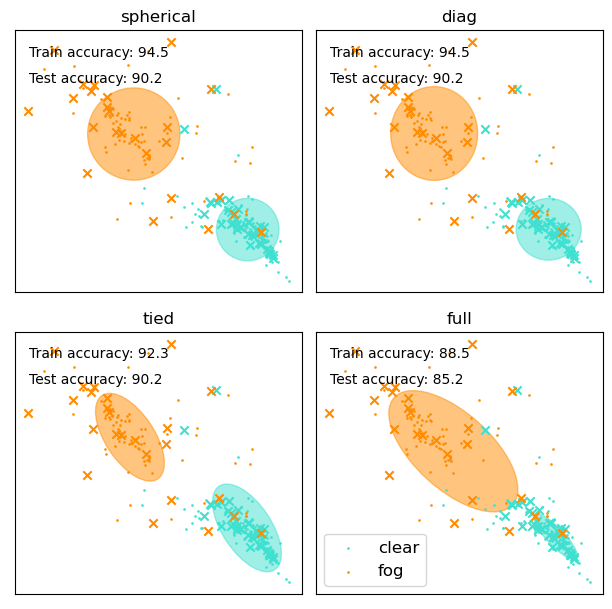

In [227]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

colors = ["turquoise", "darkorange"]


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], angle=180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")


# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(X, y)))


X_train = X[train_index]
y_train = y[train_index]
X_test = X[test_index]
y_test = y[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {
    cov_type: GaussianMixture(
        n_components=n_classes, covariance_type=cov_type, max_iter=20, random_state=0
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(
    bottom=0.01, top=0.95, hspace=0.15, wspace=0.05, left=0.01, right=0.99
)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array(
        [X_train[y_train == i].mean(axis=0) for i in range(n_classes)]
    )

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = X[y == n]
        plt.scatter(
            data[:, 0], data[:, 1], s=0.8, color=color, label=names[n]
        )
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker="x", color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, "Train accuracy: %.1f" % train_accuracy, transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, "Test accuracy: %.1f" % test_accuracy, transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc="best", prop=dict(size=12))


plt.show()


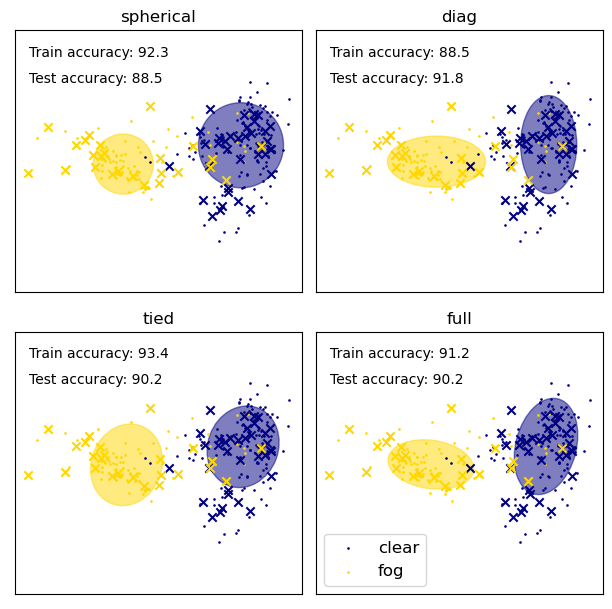

In [297]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

colors = ["navy", "gold"]


X = X_transformed_no[:, (0, 1)]
y = np.array(df_project_files['fog'])
# from sklearn.model_selection import StratifiedKFold
# skf = StratifiedKFold(n_splits=2)
# next(skf.split(X, y))
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42)

n_classes = len(np.unique(y_train))


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], angle=180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")


# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(X, y)))


X_train = X[train_index]
y_train = y[train_index]
X_test = X[test_index]
y_test = y[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {
    cov_type: GaussianMixture(
        n_components=n_classes, covariance_type=cov_type, max_iter=20, random_state=0
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(
    bottom=0.01, top=0.95, hspace=0.15, wspace=0.05, left=0.01, right=0.99
)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array(
        [X_train[y_train == i].mean(axis=0) for i in range(n_classes)]
    )

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = X[y == n]
        plt.scatter(
            data[:, 0], data[:, 1], s=0.8, color=color, label=names[n]
        )
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker="x", color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, "Train accuracy: %.1f" % train_accuracy, transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, "Test accuracy: %.1f" % test_accuracy, transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc="lower left", prop=dict(size=12))


plt.show()


In [303]:
for i in range(2, 20):
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [305]:
i

0

In [308]:
loop_train_acc

[90.72164948453609,
 93.29896907216495,
 79.89690721649485,
 78.8659793814433,
 70.10309278350515,
 72.16494845360825,
 77.83505154639175,
 82.4742268041237,
 76.28865979381443,
 23.711340206185564,
 24.742268041237114,
 81.44329896907216,
 81.44329896907216,
 72.68041237113401,
 24.22680412371134,
 27.31958762886598,
 72.68041237113401,
 72.16494845360825]

In [306]:
loop_train_acc = []
loop_test_acc = []
for i in range(2, 20):

    X = X_transformed_no[:, 0:i]

    X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.20, random_state=42)

    estimator  =GaussianMixture(
            n_components=n_classes, covariance_type='diag', max_iter=20, random_state=0
        )
    estimator.fit(X_train)

    y_train_pred = estimator.predict(X_train)
    loop_train_acc.append(np.mean(y_train_pred.ravel() == y_train.ravel()) * 100)

    y_test_pred = estimator.predict(X_test)
    loop_test_acc.append(np.mean(y_test_pred.ravel() == y_test.ravel()) * 100)

    print(loop_train_acc, loop_test_acc)


[90.72164948453609] [85.71428571428571]
[90.72164948453609, 93.29896907216495] [85.71428571428571, 87.75510204081633]
[90.72164948453609, 93.29896907216495, 79.89690721649485] [85.71428571428571, 87.75510204081633, 73.46938775510205]
[90.72164948453609, 93.29896907216495, 79.89690721649485, 78.8659793814433] [85.71428571428571, 87.75510204081633, 73.46938775510205, 75.51020408163265]
[90.72164948453609, 93.29896907216495, 79.89690721649485, 78.8659793814433, 70.10309278350515] [85.71428571428571, 87.75510204081633, 73.46938775510205, 75.51020408163265, 73.46938775510205]
[90.72164948453609, 93.29896907216495, 79.89690721649485, 78.8659793814433, 70.10309278350515, 72.16494845360825] [85.71428571428571, 87.75510204081633, 73.46938775510205, 75.51020408163265, 73.46938775510205, 73.46938775510205]
[90.72164948453609, 93.29896907216495, 79.89690721649485, 78.8659793814433, 70.10309278350515, 72.16494845360825, 77.83505154639175] [85.71428571428571, 87.75510204081633, 73.46938775510205, 75

/home/smmrrr/miniconda3/envs/condaforge/lib/python3.10/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/smmrrr/miniconda3/envs/condaforge/lib/python3.10/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/smmrrr/miniconda3/envs/condaforge/lib/python3.10/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/smmrrr/miniconda3/envs/condaforge/lib/python3.10/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for de

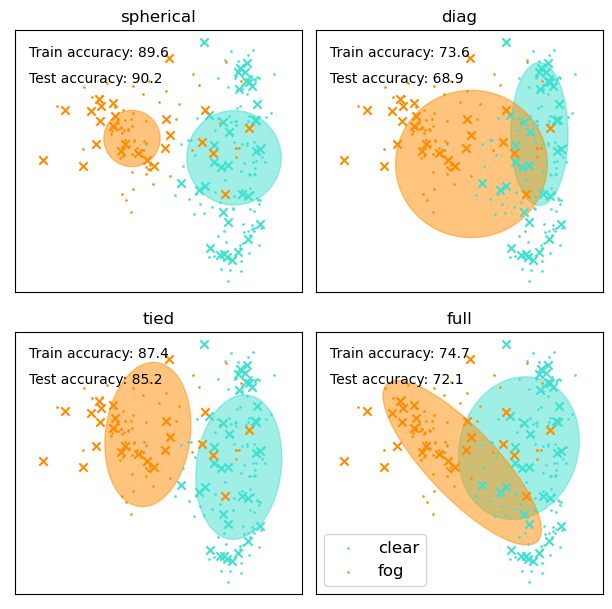

In [235]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

colors = ["turquoise", "darkorange"]


X = X_transformed_no[:, 0:9]
y = np.array(df_project_files['fog'])
# from sklearn.model_selection import StratifiedKFold
# skf = StratifiedKFold(n_splits=2)
# next(skf.split(X, y))
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42)

n_classes = len(np.unique(y_train))


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], angle=180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")


# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(X, y)))


X_train = X[train_index]
y_train = y[train_index]
X_test = X[test_index]
y_test = y[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {
    cov_type: GaussianMixture(
        n_components=n_classes, covariance_type=cov_type, max_iter=20, random_state=0
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(
    bottom=0.01, top=0.95, hspace=0.15, wspace=0.05, left=0.01, right=0.99
)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array(
        [X_train[y_train == i].mean(axis=0) for i in range(n_classes)]
    )

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = X[y == n]
        plt.scatter(
            data[:, 0], data[:, 1], s=0.8, color=color, label=names[n]
        )
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker="x", color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, "Train accuracy: %.1f" % train_accuracy, transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, "Test accuracy: %.1f" % test_accuracy, transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc="best", prop=dict(size=12))


plt.show()


In [ ]:

for index, (name, classifier) in enumerate(classifiers.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    classifier.means_ = np.array([X_train[y_train == i].mean(axis=0)
                                  for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    classifier.fit(X_train)

    h = plt.subplot(2, 2, index + 1)
    # make_ellipses(classifier, h)

    for n, color in enumerate(colors):
        data = X[y == n]
        plt.scatter(data[:, 0], data[:, 1], 0.8, color=color
                    ,label=names[n]
                   )
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.plot(data[:, 0], data[:, 1], 'x', color=color)

    y_train_pred = classifier.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = classifier.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.text(0.05, 1, 'Test iter: %.1f' % classifier.n_iter_ ,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(loc='lower right', prop=dict(size=12))


plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.extmath import row_norms
from sklearn.datasets._samples_generator import make_blobs
from timeit import default_timer as timer

print(__doc__)

# Generate some data

X, y_true = X_transformed_no[:, (0, 16)], df_project_files['fog']

n_samples = 243
n_components = 2
x_squared_norms = row_norms(X, squared=True)


def get_initial_means(X, init_params, r):
    # Run a GaussianMixture with max_iter=0 to output the initalization means
    gmm = GaussianMixture(
        n_components=2, init_params=init_params, tol=1e-9, max_iter=0, random_state=r
    ).fit(X)
    return gmm.means_


methods = ["kmeans", "random_from_data", "k-means++", "random"]
colors = ["navy", "turquoise", "cornflowerblue", "darkorange"]
times_init = {}
relative_times = {}

plt.figure(figsize=(4 * len(methods) // 2, 6))
plt.subplots_adjust(
    bottom=0.1, top=0.9, hspace=0.15, wspace=0.05, left=0.05, right=0.95
)

for n, method in enumerate(methods):
    r = np.random.RandomState(seed=1234)
    plt.subplot(2, len(methods) // 2, n + 1)

    start = timer()
    ini = get_initial_means(X, method, r)
    end = timer()
    init_time = end - start

    gmm = GaussianMixture(
        n_components=2, means_init=ini, tol=1e-9, max_iter=2000, random_state=r
    ).fit(X)

    times_init[method] = init_time
    for i, color in enumerate(colors):
        data = X[gmm.predict(X) == i]
        plt.scatter(data[:, 0], data[:, 1], color=color, marker="x")

    plt.scatter(
        ini[:, 0], ini[:, 1], s=75, marker="D", c="orange", lw=1.5, edgecolors="black"
    )
    relative_times[method] = times_init[method] / times_init[methods[0]]

    plt.xticks(())
    plt.yticks(())
    plt.title(method, loc="left", fontsize=12)
    plt.title(
        "Iter %i | Init Time %.2fx" % (gmm.n_iter_, relative_times[method]),
        loc="right",
        fontsize=10,
    )
plt.suptitle("GMM iterations and relative time taken to initialize")
plt.show()

In [ ]:

temp_no = pd.DataFrame(X_transformed_no[:,0:20]
                       ,columns = ['SPC1', 'SPC2', 'SPC3', 'SPC4','SPC5', 'SPC6', 'SPC7', 'SPC8', 'SPC9', 'SPC10',  'SPC11',  'SPC12'
                                  ,'SPC13',  'SPC14',  'SPC15','SPC16',  'SPC17',  'SPC18','SPC19',  'SPC20'] )
temp_no['fog'] = df_project_files['fog']
temp_no['rain_drops'] = df_project_files['water droplets on lense ']
temp_no['any_fog'] = df_project_files['fog present in background touching land']


In [33]:
group1 = temp_no[temp_no['fog'] == 1]
group2 = temp_no[temp_no['fog'] == 0]

stats.ttest_ind(group1, group2, equal_var=False)

Ttest_indResult(statistic=array([-19.71345211,   4.56181756,  -5.77229671, -10.08485572,
       -10.0396242 ,  -7.67950067,  -5.93617688,  -4.85487647,
        -4.45560767,  10.9592186 ,  10.97065224,  -7.98033635,
        -8.96929046, -13.19839524,  -9.55732505, -13.41725945,
        20.10679606,   4.38331836,  -2.66632636,  -8.45200547,
                inf,   6.72193089,  20.30037594]), pvalue=array([1.31671855e-41, 8.33167838e-06, 2.44670174e-08, 7.85527303e-19,
       4.88351059e-20, 9.29005424e-13, 1.18921097e-08, 2.30092394e-06,
       1.34822595e-05, 2.03806349e-22, 2.16147350e-22, 9.74839004e-14,
       8.66304411e-17, 1.91637106e-27, 2.00519567e-18, 1.35899006e-30,
       5.05757776e-43, 1.74793083e-05, 8.28721530e-03, 3.80771375e-15,
       0.00000000e+00, 8.15531304e-10, 3.18909230e-44]))

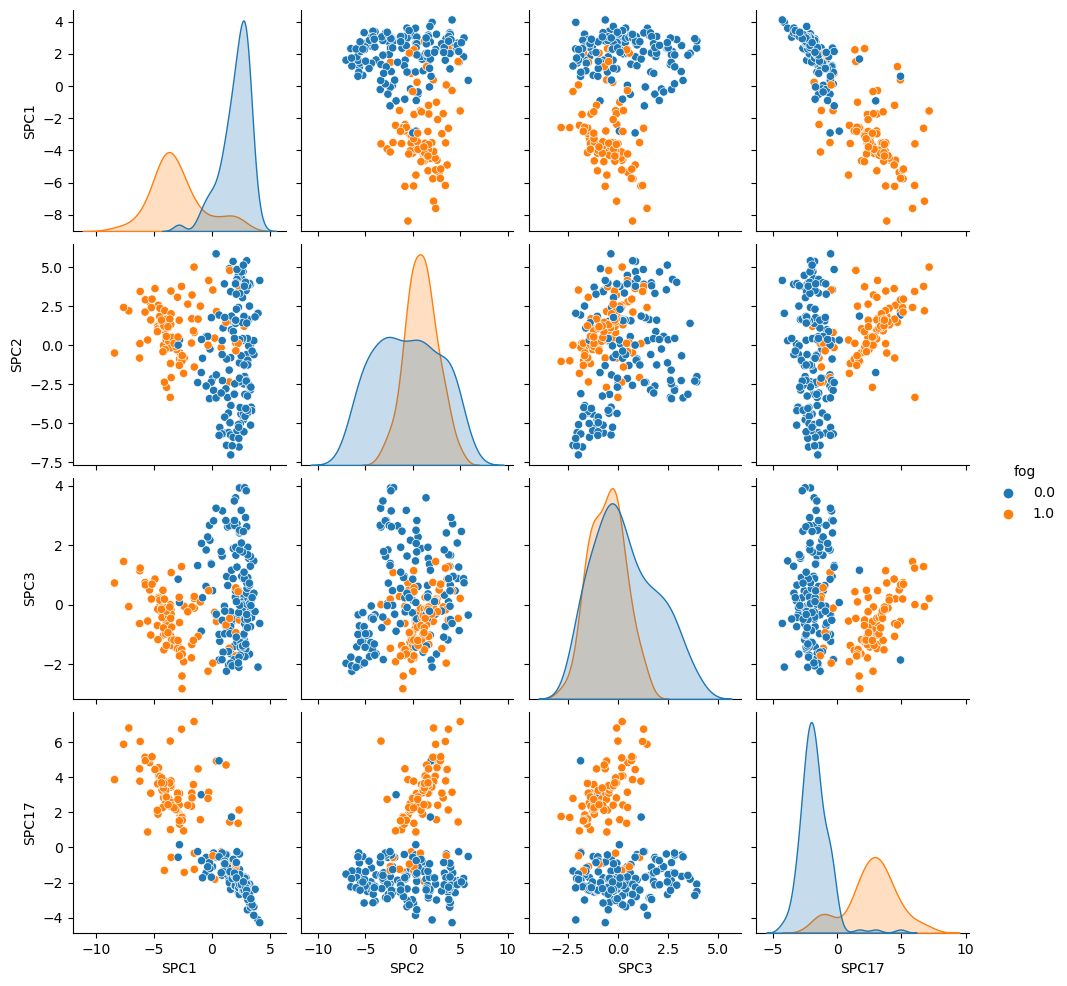

In [236]:
import seaborn as sns
sns.pairplot(temp_no[['SPC1', 'SPC2', 'SPC3', 'SPC17', 'fog']], hue = 'fog')


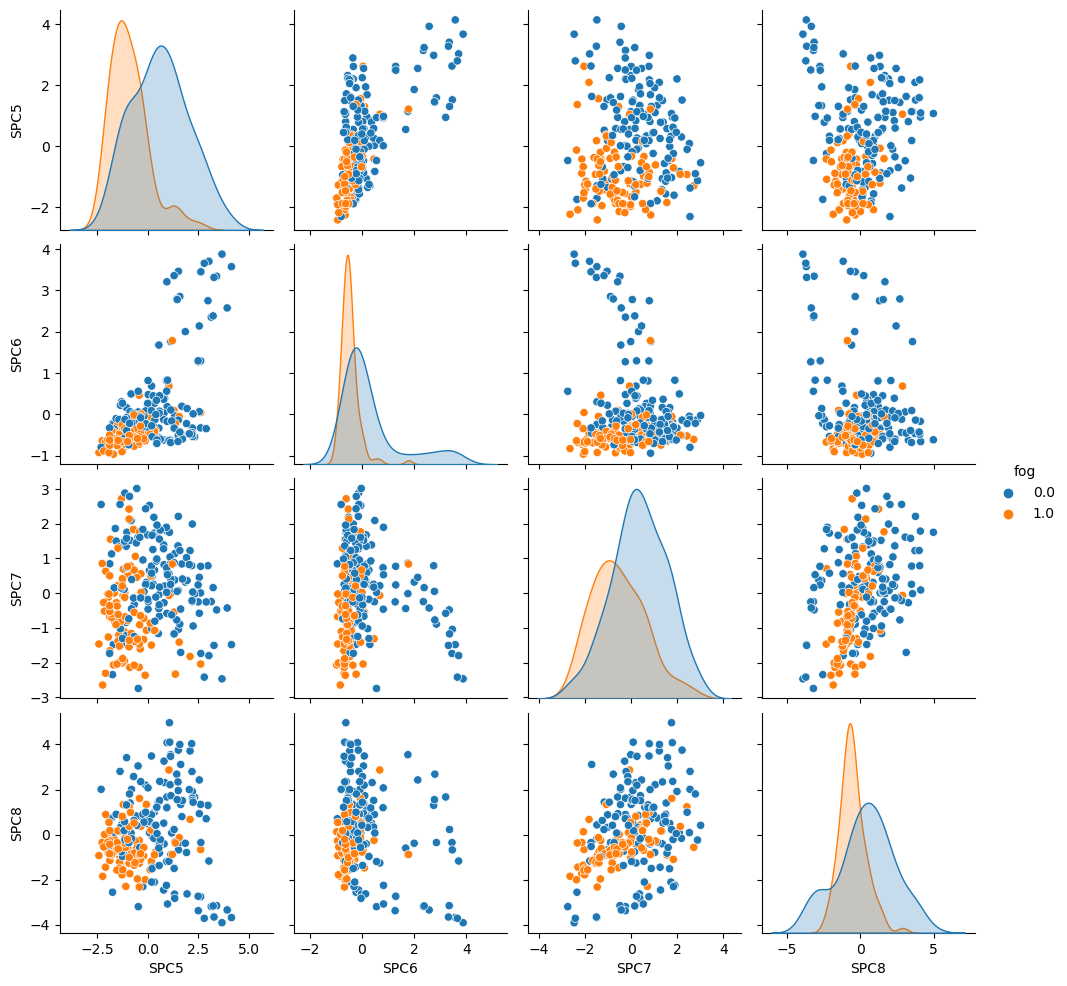

In [15]:

sns.pairplot(temp_no[['SPC5', 'SPC6', 'SPC7', 'SPC8', 'fog']], hue = 'fog')


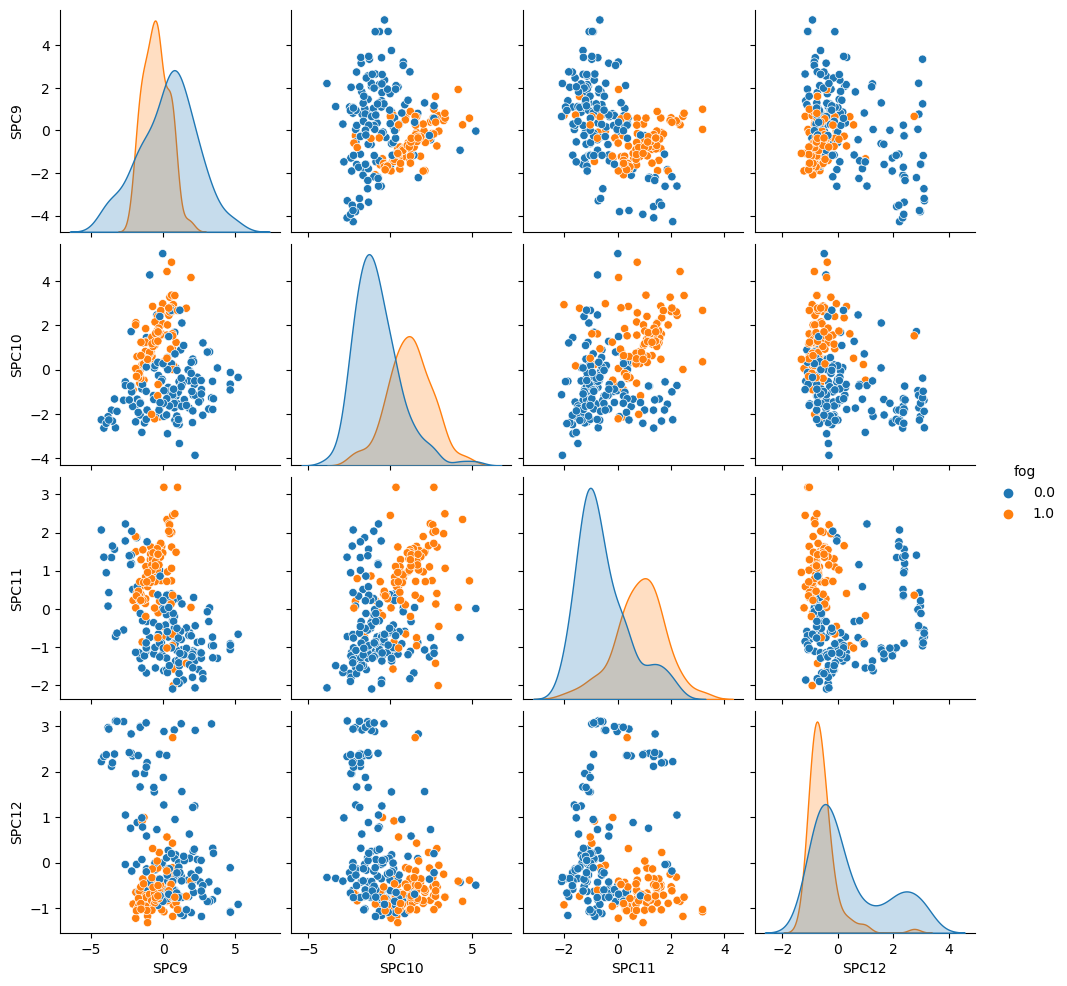

In [16]:
sns.pairplot(temp_no[['SPC9', 'SPC10', 'SPC11', 'SPC12', 'fog']], hue = 'fog')


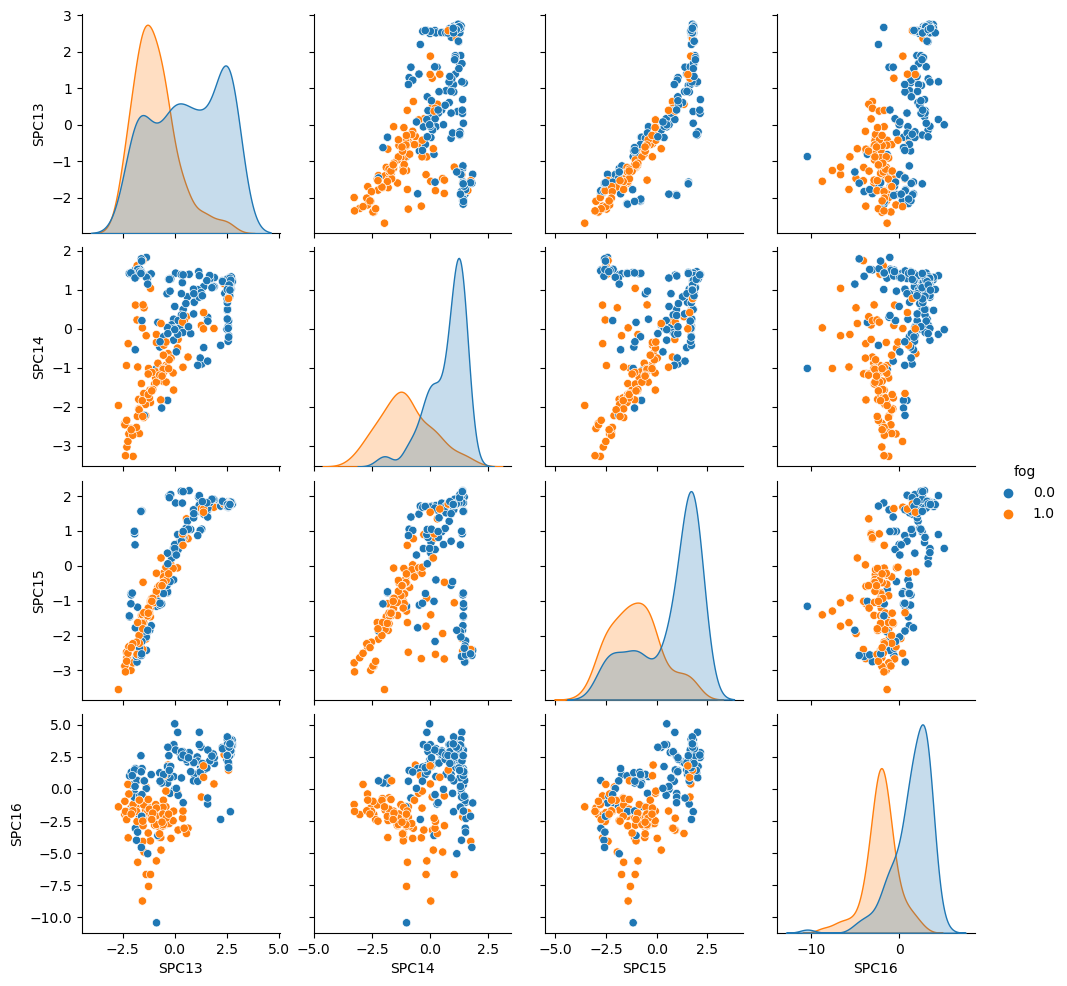

In [17]:
sns.pairplot(temp_no[['SPC13', 'SPC14', 'SPC15', 'SPC16', 'fog']], hue = 'fog')


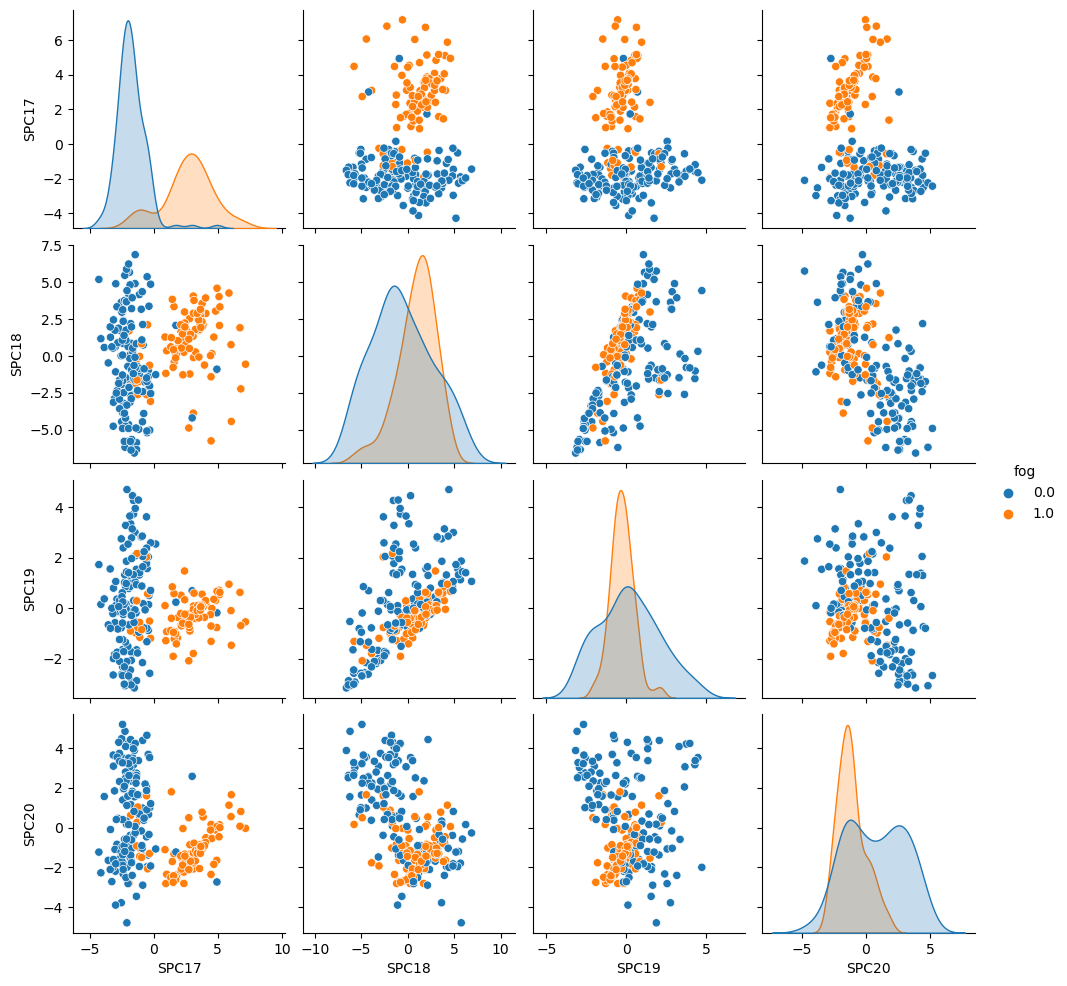

In [18]:
sns.pairplot(temp_no[['SPC17', 'SPC18', 'SPC19', 'SPC20', 'fog']], hue = 'fog')


In [17]:
X_transformed_no.shape

(243, 20)

In [92]:
for f in range(len(project_files)):
    im = io.imread(image_dir + project_files[f])
    im = im[110:950, :, :]
    im = rgb2gray(im)
    im = rescale(im, 0.1, anti_aliasing=False)
    coeffs = pywt.dwt2(im, 'db6') ## 6 or 8 for daub
    LL, (LH, HL, HH) = coeffs
    if f == 0 :
        wavelet_images = np.hstack((LL,LH, HL, HH) ).ravel()
    else:
        wavelet_images = np.vstack(( wavelet_images, np.hstack((LL,LH, HL, HH) ).ravel()))

    
wavelet_images.shape    

(243, 12972)

In [93]:

transformer = SparsePCA(n_components=20, random_state=0)
transformer.fit(wavelet_images)



SparsePCA(n_components=20, random_state=0)

In [120]:
X_transformed = transformer.transform(wavelet_images)

print(X_transformed.shape)

print(np.mean(transformer.components_ == 0) )
print((1-np.mean(transformer.components_ == 0))*12972 )


(243, 20)
0.9857153869873574
185.29999999999995


In [114]:
transformer.components_.shape

(20, 12972)

In [61]:
import plotly.express as px

np.array(df_project_files['fog']).shape


(243,)

In [84]:
df_project_files.columns

Index(['image', 'counts', 'fog present in background touching land',
       'foggy over ocean ', 'water droplets on lense ', 'Unnamed: 4', 'fog'],
      dtype='object')

In [ ]:
temp = pd.DataFrame(X_transformed[:,0:4],columns = ['SPC1', 'SPC2', 'SPC3', 'SPC4'] )
temp['fog'] = df_project_files['fog']
temp['rain_drops'] = df_project_files['water droplets on lense ']
temp['any_fog'] = df_project_files['fog present in background touching land']


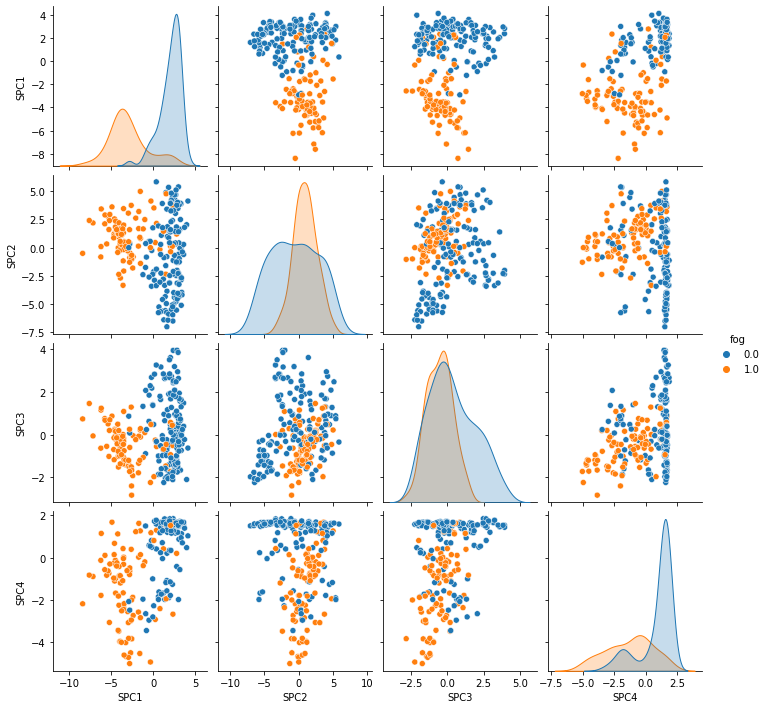

In [103]:
sns.pairplot(temp[['SPC1', 'SPC2', 'SPC3', 'SPC4', 'fog']], hue = 'fog')
 

In [ ]:
sns.pairplot(temp[['SPC1', 'SPC2', 'SPC3', 'SPC4', 'any_fog']], hue = 'any_fog')


In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans.labels_

<AxesSubplot:xlabel='SPC1', ylabel='SPC2'>

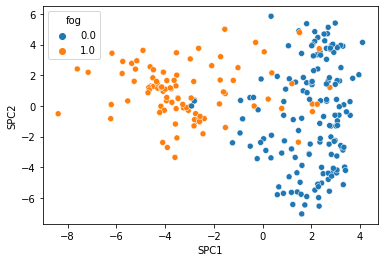

In [96]:

sns.scatterplot(data=temp, x="SPC1", y="SPC2", hue="fog")

<AxesSubplot:xlabel='SPC1', ylabel='SPC3'>

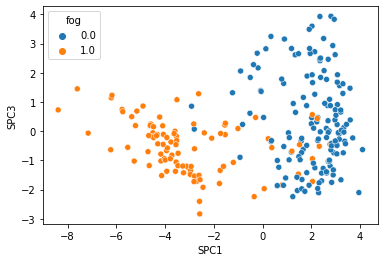

In [97]:
sns.scatterplot(data=temp, x="SPC1", y="SPC3", hue="fog")

<AxesSubplot:xlabel='SPC1', ylabel='SPC4'>

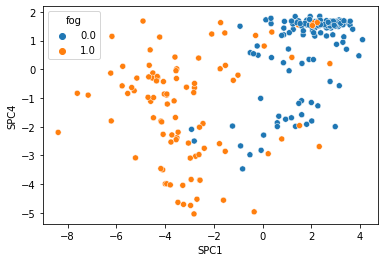

In [98]:
sns.scatterplot(data=temp, x="SPC1", y="SPC4", hue="fog")

<AxesSubplot:xlabel='SPC3', ylabel='SPC2'>

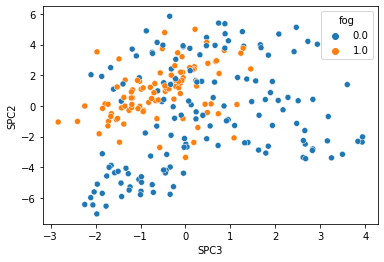

In [99]:
sns.scatterplot(data=temp, x="SPC3", y="SPC2", hue="fog")

<AxesSubplot:xlabel='SPC1', ylabel='SPC2'>

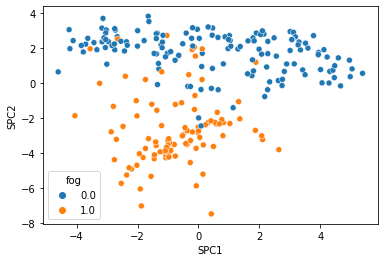

In [85]:
import seaborn as sns
temp = pd.DataFrame(X_transformed[:,0:4],columns = ['SPC1', 'SPC2', 'SPC3', 'SPC4'] )
temp['fog'] = df_project_files['fog']
temp['rain_drops'] = df_project_files['water droplets on lense ']
temp['any_fog'] = df_project_files['fog present in background touching land']

sns.scatterplot(data=temp, x="SPC1", y="SPC2", hue="fog")

<AxesSubplot:xlabel='SPC1', ylabel='SPC2'>

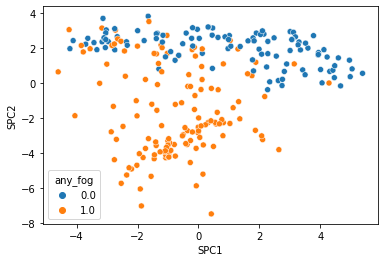

In [89]:
sns.scatterplot(data=temp, x="SPC1", y="SPC2", hue="any_fog")

<AxesSubplot:xlabel='SPC1', ylabel='SPC3'>

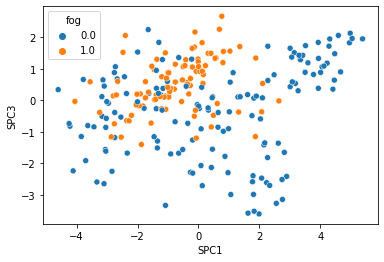

In [82]:
sns.scatterplot(data=temp, x="SPC1", y="SPC3", hue="fog")

<AxesSubplot:xlabel='SPC1', ylabel='SPC3'>

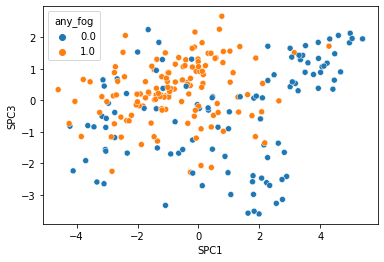

In [90]:
sns.scatterplot(data=temp, x="SPC1", y="SPC3", hue="any_fog")

<AxesSubplot:xlabel='SPC1', ylabel='SPC4'>

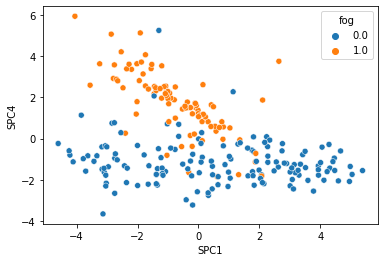

In [83]:
sns.scatterplot(data=temp, x="SPC1", y="SPC4", hue="fog")

<AxesSubplot:xlabel='SPC1', ylabel='SPC4'>

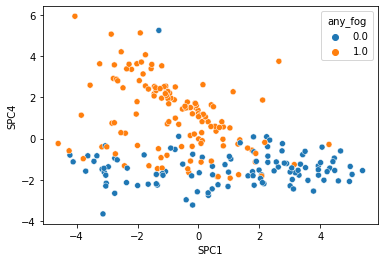

In [91]:
sns.scatterplot(data=temp, x="SPC1", y="SPC4", hue="any_fog")

In [ ]:
sns.scatterplot(data=temp, x="SPC1", y="SPC2", hue="fog")

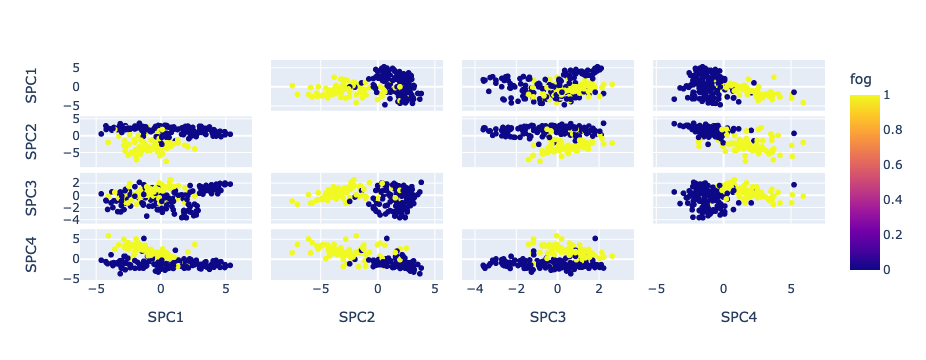

In [79]:
import plotly.express as px
features = ['SPC1', 'SPC2', 'SPC3', 'SPC4']

fig = px.scatter_matrix(
temp
, color = temp['fog']
,     dimensions=features
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [26]:

# Application 1: truncated svd vs optshrink algorithm
def Optshrink(Y,r):
    Y=np.mat(Y)
    U,s,V=np.linalg.svd(Y)
    m,n=Y.shape
    r=min(r,m,n)
    if m >= n:
        S=np.concatenate([np.diag(s[r:n]),np.zeros([(m-n),(n-r)])], axis=0)
    else:
        S=np.concatenate([np.diag(s[r:m]),np.zeros([(m-r),(n-m)])], axis=1)
    w=np.zeros(r)
    for k in range(0,r):
        D,Dder=D_transfrom_from_matrix(s[k],S)
        w[k]=-2*D/Dder
    Xh = U[:,0:r]*np.diag(w)*V[0:r:,]
    return Xh

def D_transfrom_from_matrix(z,X):
    X=np.mat(X)
    n,m=X.shape
    In=np.mat(np.diag(np.ones(n)))
    Im=np.mat(np.diag(np.ones(m)))
    D1=np.trace(z*(z*z*In-X*X.T)**(-1))/n
    D2=np.trace(z*(z*z*Im-X.T*X)**(-1))/m
    D=D1*D2
    D1_der=np.trace(-2*z*z*(z*z*In-X*X.T)**(-2)+(z*z*In-X*X.T)**(-1))/n
    D2_der=np.trace(-2*z*z*(z*z*Im-X.T*X)**(-2)+(z*z*Im-X.T*X)**(-1))/m
    D_der=D1*D2_der+D2*D1_der
    return D, D_der






# Application 2 : digit classification
# data exploration
def data_exploration(train_t):
    fig=plt.figure(figsize=(11,11))
    m,n,p=train_t.shape
    row=4
    column=5
    for i in range(1,row+1): 
        if  i%2 == 1:
            train=train_t+66*np.random.normal(np.zeros([m, n, p]))
            for j in range(0,column):
                digit=np.reshape(train[:,:,int(j+5*(i-1)/2)][:,1], [28,28])
                fig.add_subplot(row, column, 5*(i-1)+j+1, title='nosie plus digit ' + str(int(j+5*(i-1)/2)))
                plt.imshow(digit, cmap=plt.get_cmap('gray'))         
        if i%2 == 0:
            train=train_t
            for j in range(0,column):
                digit=np.reshape(train[:,:,int(j+5*(i-2)/2)][:,1], [28,28])
                fig.add_subplot(row, column, 5*(i-2)+j+1+5, title='original digit ' + str(int(j+5*(i-2)/2)))
                plt.imshow(digit, cmap=plt.get_cmap('gray'))
            

# function to change traindata (10,800,784) to (784,800,10)
def transformation_matrix(train):
    m,n,b=train.shape
    train_t=np.zeros([b,n,m])
    for i in range(0,m):
        for j in range(0,n):
            train_t[:,:,i][:,j]=train[i,:,:,][j,:]
    return train_t

# after model selection, we use the parameter r = 10. 
def nearest_ss_optshrink(train, ktrain): # ktrain = n
    n,N,d=train.shape
    U=np.zeros([n,ktrain,d])
    for j in range(0,d):
        Uj=np.linalg.svd(Optshrink(train[:,:,j],10))[0]
        U[:,:,j]=Uj[:,0:ktrain]
    return U

def nearest_ss(train, k): # ktrain = n
    n,N,d=train.shape
    U=np.zeros([n,k,d])
    for j in range(0,d):
        Uj=np.linalg.svd(train[:,:,j])[0]
        U[:,:,j]=Uj[:,0:k]
    return U

def classify_manylabels(test, U, k, test_label): 
    correst=0
    n,p=test.shape
    d=U.shape[2]
    err=np.zeros([d,p])
    for j in range(0,d):
        Uj=U[:,0:k-1,j]
        err[j,:]=np.sum(np.square(np.mat(test)-np.mat(Uj)*(np.mat(Uj).T*np.mat(test))),axis=0)
    label=np.argmin(err,axis=0)
    for i in range(0,len(label)):
        if label[i]==test_label[i]:
            correst+=1
    pcorrect=correst/len(label)
    return pcorrect

def accuary_plot(test,opt_U,orig_U,testlabel,maxN):
    pcorrect_opt=[]
    pcorrect_orig=[]
    for i in range(0,maxN):
        pcorrect_opt.append(classify_manylabels(test, opt_U, i+1, test_label))
    max_position=np.argmax(pcorrect_opt)
    max_value=pcorrect_opt[max_position]
    for i in range(0,maxN):
        pcorrect_orig.append(classify_manylabels(test, orig_U, i+1, test_label))
    plt.figure(figsize=(8,6))
    plt.plot(range(1,maxN+1), pcorrect_opt, c='blue', label='noise digit')
    plt.plot(range(1,maxN+1), pcorrect_orig, c='orange',linestyle='--', label='pure digit')
    plt.axvline(x=max_position+1, c='green', linestyle='--')
    plt.scatter([max_position+1], [max_value],c='red')
    plt.xlabel("Rank of the matrix")
    plt.ylabel("Accuracy %")
    plt.title('best classification accuracy = ' + str(max_value))
    plt.legend(loc='lower right', shadow=True)
    plt.show()
    return pcorrect_opt

def parameter_selection_opt(train_t, test_t, test_label, maxN, noise):
    m,n,p=train_t.shape
    train_n=train_t-noise*np.random.normal(np.zeros([m,n,p]))
    a,b=test_t.shape
    test_n=test_t-66*np.random.normal(np.zeros([a,b]))
    best_pcorrect=[]
    for r in range(1, 21):
        train_U_o=nearest_ss_optshrink(train_n, 10, r)
        pcorrect_opt=[]
        for i in range(0,maxN):
            pcorrect_opt.append(classify_manylabels(test_n, train_U_o, i+1, test_label))
        max_position_opt=np.argmax(pcorrect_opt)
        max_value_opt=pcorrect_opt[max_position_opt]
        best_pcorrect.append(max_value_opt)
    return best_pcorrect


    

    
    

# # load data
# traindata=h5py.File('train_digits.mat')
# train=np.array(traindata["train_data"]) 
# train_t=transformation_matrix(train)
# testdata=h5py.File('test_digits.mat')
# test_label=np.array(testdata["test_label"]) 
# test_data=np.array(testdata["test_data"]) 
# test_data=test_data.T 
# # our pure data: train, test_data, test_label

# # noise dataset:
# np.random.seed(0)
# m,n,p=train_t.shape
# train_n=train_t-100*np.random.normal(np.zeros([m,n,p]))
# a,b=test_data.shape
# test_n=test_data-100*np.random.normal(np.zeros([a,b]))